# ODE predictions of inputs


Debugging steps, subject to delete later.

PREDICTION QUALITY DIAGNOSTICS
Optimizer failures (hit bounds): 29.0/126 (23.0%)
aTc: 7 at lower bound, 20 at upper bound
  97/126 predictions within original data range (77.0%)
IPTG: 2 at lower bound, 1 at upper bound
  105/126 predictions within original data range (83.3%)

Cost statistics:
  Mean cost: 0.319182
  Median cost: 0.261622
  Max cost: 1.827752
  High cost samples (>95th percentile): 7

Creating log scale plot for comparison...


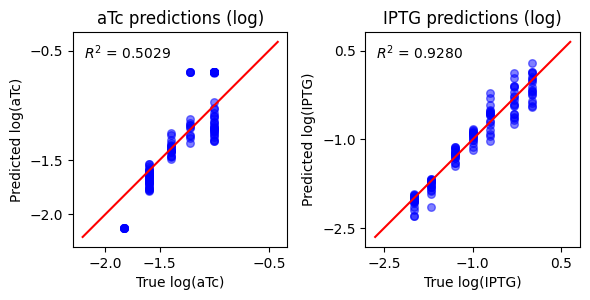

In [1]:
#import python packages
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import glob
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from data_loading_v5 import define_metadata, import_exp_data, filter_dataframes, process_dataframes, convert_reader_data, subtract,normalize 
from plot_timecourses import plottimecourselist, plottimecoursearray, figure_layout 
from crosstalk import crosstalk, mixed_crosstalk, antibiotic_crosstalk
from dose_response_fitting import dose_response_fitting
from mechanistic_model import difeq_newest_test_2, fp_total_timecourse, sensor_fit, plot_fittings
from VAE import VAE, train, test, warmup_scheduler, get_latent_variables, count_parameters
from VAEMLP import MLP, CombinedModel, combo_train, validate

#select which microbial community dataset to work with
community='aTc_IPTG' #list of options: 'aTc_IPTG','TTR_THS','cuma_ohc_atc','van_dapg_nar', 'antibiotic_data', 'ttr_ths_ph'

#if using antibiotic data, indicate the plasmid and inhibitor combination
plasmid='BlaM' #options: 'Bla', 'BlaM', 'HSGBla', 'HSGBlaM'
inhibitor='SUL' #options: 'TAZ', 'SUL'
if community!='antibiotic_data':
    plasmid=None
    inhibitor=None

#import metadata for selected community
files,readers, fluors, fluor1, fluor2, fluor3, single_file, sensor_names, sensors,time_vector,od_raws,input_arrays,input_names,fp1_raws,fp2_raws,fp3_raws = define_metadata(community,plasmid,inhibitor)

if community=='antibiotic_data':
    od_conv=od_raws
    fp1_conv=fp1_raws
    fp2_conv=fp2_raws
    fp3_conv=None
else:
    # convert the plate reader data to match based on calibrations
    od_conv=convert_reader_data(readers, None, od_raws,community)
    fp1_conv=convert_reader_data(readers, fluor1, fp1_raws,community)
    fp2_conv=convert_reader_data(readers, fluor2, fp2_raws,community)
    if sensors==3:
        fp3_conv=convert_reader_data(readers, fluor3, fp3_raws,community)
    else:
        fp3_conv=None

# Subtract basal expression (sample with 0 inducers added) time course from all time courses of the same experiment 
subtracted_fp1_conv_all, subtracted_fp2_conv_all, subtracted_fp3_conv_all=subtract(community,time_vector,fp1_conv,fp2_conv,fp3_conv,sensors,input_arrays)

# Min-max scale each fluorescence time course to be on a scale from 0-1
normalized_fp1_conv_all, normalized_fp2_conv_all, normalized_fp3_conv_all=normalize(subtracted_fp1_conv_all,subtracted_fp2_conv_all,subtracted_fp3_conv_all)

#Append the full OD and fluorescence timecourses from the normalized dataset
#stack the OD time courses to be in the same format the fluorescence curves are
od_stack=np.empty((0,len(time_vector)), dtype=float)
for i, reader in enumerate(fluor1):
    od_stack=np.vstack((od_stack,od_conv[i]))
# Initialize the list of arrays to concatenate
concat_list = [od_stack]
#append each time course
concat_list.append(normalized_fp1_conv_all)
concat_list.append(normalized_fp2_conv_all)
if normalized_fp3_conv_all is not None and normalized_fp3_conv_all.size>0:  # Check if fp3 is None
    concat_list.append(normalized_fp3_conv_all)
exp_data_new=np.concatenate(concat_list,axis=1)
    
#concatenate all experimental input data into one array
exp_inputs=np.vstack(list(input_arrays.values())) #used to be normalized_input_arrays

'''load the calculated sensor parameter values if not calculating them this time'''
#choose timepoint calculation for alpha you want to import
timepoint=20 
if community=='antibiotic_data':
    save_dir = f"parameter_files/{community}/{plasmid}_{inhibitor}/"
else:
    save_dir = f"parameter_files/{community}/"

alpha_files=glob.glob(f'{save_dir}*_{timepoint}hr_{community}_alphas_mixed.npy') # List all matching files
alphas=np.load(max(alpha_files)) #load the most recent K calc file

#choose timept calculation for hill parameters you want to import
hill_timepoint=20 

K_files=glob.glob(f'{save_dir}*_{hill_timepoint}hr_{community}_K_calc.npy') # List all matching files
K_calc=np.load(max(K_files)) #load the most recent K calc file
    
hill_files=glob.glob(f'{save_dir}*_{hill_timepoint}hr_{community}_hill_coef.npy') # List all matching files
hill_calc=np.load(max(hill_files)) #load the most recent hill calc file

'''normalize inputs and K_calc with K_calc (everything will be centered around 1 and K will be 1 for each sensor)'''

'''calculate the limit range for inputs based on K and n'''
# extract true_K = K_calc for the respective intended sensor
true_K=np.zeros(sensors) #true_K= K values in same order as input 1, input 2
upper=np.zeros(sensors)
lower=np.zeros(sensors)
for i in range(sensors):
    true_K[i]=K_calc[i*sensors + i] 
    upper[i]=true_K[i]*(99**(1/hill_calc[i*sensors + i]))
    lower[i]=true_K[i]/(99**(1/hill_calc[i*sensors + i])) 

'''Remove data where inputs are outside threshold limits'''
if ((community=='cuma_ohc_atc')|(community=='van_dapg_nar')|(community=='antibiotic_data')):
    mask=(exp_inputs>0).all(axis=1)
else:
    mask = (exp_inputs >= lower).all(axis=1) & (exp_inputs <= upper).all(axis=1) 
# Filter the arrays based on the mask
filtered_exp_inputs = exp_inputs[mask]
filtered_exp_data_new = exp_data_new[mask]

'''normalize inputs and K_calc with the K value for the intended sensor'''
# Normalize the filtered inputs array by dividing by K
normalized_exp_inputs = filtered_exp_inputs / true_K
normalized_K_calc=K_calc.reshape((sensors,sensors))/true_K #reshaped to make the calculation easier and needs to be reshaped for the ODEs anyway

#define fit function for estimating inputs from time courses using nonlinear optimization
def ode_input_pred(sensors,samples,tspan,all_params,alpha,K,hill):

    #extract initial values array (n_sample,3)
    inits_train=samples[0::len(tspan)]

    n=sensors #number of sensors 
    s_ref=np.diag(K)

    #FIXED: Calculate bounds based on filtered data range with appropriate margins
    filtered_min = np.min(normalized_exp_inputs, axis=0)
    filtered_max = np.max(normalized_exp_inputs, axis=0) 
    margin_factor = 2.0
    bounds_lower = np.maximum(0.01, filtered_min / margin_factor)  # Don't go below 0.01
    bounds_upper = filtered_max * margin_factor
    
    #set bounds for params - FIXED FORMAT
    bounds=np.array([bounds_lower, bounds_upper])
 
    #define residual function
    def residual_function(s_ref, y_data, time_range,p_0,all_params,alpha,K,hill):
        # s_ref: reference S for fitting
        # time: Time step indices for simulation (same as sparse time points)
        # y_data: Indexing sparse data points from the simulation for later fitting
        # time_range: full time span of time points (not sparse)
        # p_0: initial population conditions
        
        params_reshape=all_params.reshape(n,7)       
        results=[]
        
        #set initial conditions for each sample
        od_0=p_0[0]/2 #set initial cell density
        fluor_0=p_0[1:]/od_0 #set initial fluor/cell
        yinit=np.zeros(2*n)
        yinit[:n]=od_0
        yinit[n:]=fluor_0
        #solve ODEs
        sol=solve_ivp(lambda t, y: difeq_newest_test_2(t,y,params_reshape,alpha,K,hill,s_ref,n),
                  [time_range[0],time_range[-1]],yinit,t_eval=time_range)
        #obtain total od and total fluorescence values (1+sensors,time) where time is the indexed time
        results=fp_total_timecourse(sol.y,n,n).ravel() #flatten the 2d array into 1D with sparse data, append each result onto each other
        results=np.hstack(results) 
        residuals=results-y_data

        return residuals

    #FIXED: Better initial guess based on median of filtered data
    # s_ref = np.median(normalized_exp_inputs, axis=0)

    #start fitting each sample
    result = least_squares(
        fun=residual_function, x0=s_ref, bounds=bounds, 
        method='trf', args=(samples,tspan,inits_train,all_params,alpha,K,hill), 
        max_nfev=300  
    )

    #reconstruct the fitted parameters: mu_rec, Ks_rec, theta_rec
    sens_popt=result.x
    cost=result.cost
    return sens_popt, cost 

from scipy.optimize import least_squares
from scipy.integrate import odeint, solve_ivp

#load optimized parameters for this data set
params_files=glob.glob(f'{save_dir}*_{community}_params.npy') # List all matching files
all_params_test=np.load(max(params_files)) #load the most recent params file

#reshape parameters
alpha=alphas.reshape((sensors,sensors))
hill=hill_calc.reshape((sensors,sensors))

#initialize inputs arrays and test cost array
s_est=np.zeros((len(filtered_exp_data_new),sensors)) #number of experiments to iterate through by number of params optimizing
test_cost=np.zeros(len(filtered_exp_data_new))

#run nonlinear optimation for each sample to estimate its input conditions
for i,sample in enumerate(filtered_exp_data_new):
    s_est[i],test_cost[i]=ode_input_pred(sensors,sample,time_vector,all_params_test,alpha,normalized_K_calc,hill)

#save predictions
if community=='antibiotic_data':
    save_dir = f"ODE_predictions/{community}/{plasmid}_{inhibitor}/"
else:
    save_dir = f"ODE_predictions/{community}/"

os.makedirs(save_dir, exist_ok=True)
datestamp = datetime.now().strftime("%Y-%m-%d") # Format: YYYY-MM-DD
np.save(f'{save_dir}{datestamp}_{community}_ode_predictions.npy', s_est)
np.save(f'{save_dir}{datestamp}_{community}_ode_input_predictions_cost.npy',test_cost)

# DIAGNOSTIC: Check for optimizer failures
print("="*60)
print("PREDICTION QUALITY DIAGNOSTICS")
print("="*60)

filtered_min = np.min(normalized_exp_inputs, axis=0)
filtered_max = np.max(normalized_exp_inputs, axis=0)
margin_factor = 2.0
bounds_lower = np.maximum(0.01, filtered_min / margin_factor)
bounds_upper = filtered_max * margin_factor

bound_failures = np.zeros(len(s_est))
for i, pred in enumerate(s_est):
    # Check if any prediction is at or very close to bounds
    at_lower = np.any(pred <= bounds_lower * 1.01)  # within 1% of lower bound
    at_upper = np.any(pred >= bounds_upper * 0.99)  # within 1% of upper bound
    bound_failures[i] = at_lower or at_upper

failed_fits = np.sum(bound_failures)
print(f"Optimizer failures (hit bounds): {failed_fits}/{len(s_est)} ({100*failed_fits/len(s_est):.1f}%)")

# Separate analysis by sensor
for j in range(sensors):
    at_lower_sensor = np.sum(s_est[:, j] <= bounds_lower[j] * 1.01)  
    at_upper_sensor = np.sum(s_est[:, j] >= bounds_upper[j] * 0.99)
    within_data_range = np.sum((s_est[:, j] >= filtered_min[j]) & (s_est[:, j] <= filtered_max[j]))
    print(f"{input_names[j]}: {at_lower_sensor} at lower bound, {at_upper_sensor} at upper bound")
    print(f"  {within_data_range}/{len(s_est)} predictions within original data range ({100*within_data_range/len(s_est):.1f}%)")

print(f"\nCost statistics:")
print(f"  Mean cost: {np.mean(test_cost):.6f}")
print(f"  Median cost: {np.median(test_cost):.6f}")
print(f"  Max cost: {np.max(test_cost):.6f}")
print(f"  High cost samples (>95th percentile): {np.sum(test_cost > np.percentile(test_cost, 95))}")

#define path to save figures and function for plotting
if community=='antibiotic_data':
    save_dir = f"figures/{community}/{plasmid}_{inhibitor}/"
else:
    save_dir = f"figures/{community}/"

def round_to_nearest_half(value):
    return round(value * 2) / 2


print(f"\nCreating log scale plot for comparison...")
fig_log, ax_log = plt.subplots(1, 2, figsize=(6, 3))


# First, create the un-normalized inputs
original_inputs = true_K * normalized_exp_inputs  # Convert back to original scale
predicted_inputs = true_K * s_est  # Convert back to original scale

# Ensure no zeros/negatives for log transform
safe_original = np.maximum(original_inputs, 1e-10)
safe_predicted = np.maximum(predicted_inputs, 1e-10)

# Now take the log
original_inputs_log = np.log10(safe_original)
predicted_inputs_log = np.log10(safe_predicted)


for i in range(original_inputs_log.shape[1]):
    min_val = np.min([np.min(original_inputs_log[:,i]),np.min(predicted_inputs_log[:,i])])
    max_val = np.max([np.max(original_inputs_log[:,i]),np.max(predicted_inputs_log[:,i])])
    ticks=[round_to_nearest_half(min_val),round_to_nearest_half((min_val + max_val) / 2),round_to_nearest_half(max_val)]
    min_val_w_ticks=np.min([min_val,np.min(ticks)])
    max_val_w_ticks=np.max([max_val,np.max(ticks)])
    data_range = max_val_w_ticks - min_val_w_ticks
    padding = 0.05 * data_range
    new_min = min_val_w_ticks - padding
    new_max = max_val_w_ticks + padding

    ax_log[i].scatter(original_inputs_log[:,i],predicted_inputs_log[:,i],s=30,color='blue',alpha=0.5)
    ax_log[i].plot([new_min, new_max], [new_min, new_max],'r')
    ax_log[i].set_aspect('equal',adjustable='box')
    ax_log[i].set_title(f'{input_names[i]} predictions (log)')
    ax_log[i].set_xticks(ticks)
    ax_log[i].set_yticks(ticks)
    r2_log = r2_score(original_inputs_log[:, i], predicted_inputs_log[:,i])
    ax_log[i].text(0.05, 0.95,fr'$R^2$ = {r2_log:.4f}', transform=ax_log[i].transAxes, verticalalignment='top')
    ax_log[i].set_xlabel(f'True log({input_names[i]})')
    ax_log[i].set_ylabel(f'Predicted log({input_names[i]})')

plt.tight_layout()
fig_log.savefig(f'{save_dir}ODE_input_predictions_log_scale.svg',format='svg')
plt.show()


The following code is for all the communities. It is a refactored code. 

## Irida work Oct 15th

### Important: needs to be checked and verified.

In [2]:
def plot_cost_statistics(test_cost, community, plasmid=None, inhibitor=None):
    """Create comprehensive cost statistics visualizations"""
    save_dir = get_save_dir("figures", community, plasmid, inhibitor)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Plot 1: Histogram of costs
    axes[0, 0].hist(test_cost, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(np.mean(test_cost), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(test_cost):.6f}')
    axes[0, 0].axvline(np.median(test_cost), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(test_cost):.6f}')
    axes[0, 0].set_xlabel('Cost')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Optimization Costs')
    axes[0, 0].legend()
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Plot 2: Log scale histogram
    axes[0, 1].hist(np.log10(test_cost), bins=50, color='coral', edgecolor='black', alpha=0.7)
    axes[0, 1].set_xlabel('log10(Cost)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Distribution of log10(Costs)')
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Plot 3: Cumulative distribution
    sorted_costs = np.sort(test_cost)
    cumulative = np.arange(1, len(sorted_costs) + 1) / len(sorted_costs)
    axes[1, 0].plot(sorted_costs, cumulative, linewidth=2, color='darkblue')
    axes[1, 0].axvline(np.percentile(test_cost, 95), color='red', linestyle='--', linewidth=2, label='95th percentile')
    axes[1, 0].axhline(0.95, color='red', linestyle=':', alpha=0.5)
    axes[1, 0].set_xlabel('Cost')
    axes[1, 0].set_ylabel('Cumulative Proportion')
    axes[1, 0].set_title('Cumulative Distribution of Costs')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    
    # Plot 4: Box plot and statistics
    axes[1, 1].boxplot(test_cost, vert=True)
    axes[1, 1].set_ylabel('Cost')
    axes[1, 1].set_title('Box Plot of Costs')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    # Add statistics text
    stats_text = f"""
    Mean:        {np.mean(test_cost):.6f}
    Median:      {np.median(test_cost):.6f}
    Std Dev:     {np.std(test_cost):.6f}
    Min:         {np.min(test_cost):.6f}
    Max:         {np.max(test_cost):.6f}
    95th pctl:   {np.percentile(test_cost, 95):.6f}
    99th pctl:   {np.percentile(test_cost, 99):.6f}
    """
    axes[1, 1].text(0.5, 0.5, stats_text, transform=axes[1, 1].transAxes,
                   verticalalignment='center', horizontalalignment='center',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                   fontfamily='monospace', fontsize=9)
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()


def plot_prediction_quality_diagnostics(s_est, normalized_exp_inputs, input_names, sensors, community, plasmid=None, inhibitor=None):
    """Create visualizations for prediction quality and bound analysis"""
    save_dir = get_save_dir("figures", community, plasmid, inhibitor)
    
    # Calculate bounds
    filtered_min = np.min(normalized_exp_inputs, axis=0)
    filtered_max = np.max(normalized_exp_inputs, axis=0)
    margin_factor = 2.0
    bounds_lower = np.maximum(0.01, filtered_min / margin_factor)
    bounds_upper = filtered_max * margin_factor
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Per-sensor bound violations
    bound_violations_lower = np.zeros(sensors)
    bound_violations_upper = np.zeros(sensors)
    within_range = np.zeros(sensors)
    
    for j in range(sensors):
        bound_violations_lower[j] = np.sum(s_est[:, j] <= bounds_lower[j] * 1.01)
        bound_violations_upper[j] = np.sum(s_est[:, j] >= bounds_upper[j] * 0.99)
        within_range[j] = np.sum((s_est[:, j] >= filtered_min[j]) & (s_est[:, j] <= filtered_max[j]))
    
    x_pos = np.arange(sensors)
    width = 0.25
    axes[0, 0].bar(x_pos - width, bound_violations_lower, width, label='At Lower Bound', color='lightcoral')
    axes[0, 0].bar(x_pos, bound_violations_upper, width, label='At Upper Bound', color='lightsalmon')
    axes[0, 0].bar(x_pos + width, within_range, width, label='Within Data Range', color='lightgreen')
    axes[0, 0].set_xlabel('Sensor')
    axes[0, 0].set_ylabel('Number of Predictions')
    axes[0, 0].set_title('Bound Violations and Valid Range by Sensor')
    axes[0, 0].set_xticks(x_pos)
    axes[0, 0].set_xticklabels(input_names, rotation=45, ha='right')
    axes[0, 0].legend()
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Plot 2: Percentage within valid ranges
    percentages_within = (within_range / len(s_est)) * 100
    colors = ['green' if p > 80 else 'orange' if p > 50 else 'red' for p in percentages_within]
    axes[0, 1].bar(input_names, percentages_within, color=colors, edgecolor='black', alpha=0.7)
    axes[0, 1].set_ylabel('Percentage (%)')
    axes[0, 1].set_title('Predictions Within Original Data Range')
    axes[0, 1].set_ylim([0, 105])
    axes[0, 1].axhline(80, color='green', linestyle='--', alpha=0.5, label='80% threshold')
    axes[0, 1].axhline(50, color='orange', linestyle='--', alpha=0.5, label='50% threshold')
    axes[0, 1].set_xticklabels(input_names, rotation=45, ha='right')
    axes[0, 1].legend()
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    for i, (name, pct) in enumerate(zip(input_names, percentages_within)):
        axes[0, 1].text(i, pct + 2, f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # Plot 3: Distribution of predictions vs bounds for each sensor
    for j in range(min(2, sensors)):  # Show first 2 sensors
        ax_idx = (1, j)
        ax = axes[ax_idx]
        
        ax.hist(s_est[:, j], bins=40, alpha=0.6, color='steelblue', edgecolor='black', label='Predictions')
        ax.axvline(filtered_min[j], color='green', linestyle='--', linewidth=2, label=f'Min: {filtered_min[j]:.4f}')
        ax.axvline(filtered_max[j], color='orange', linestyle='--', linewidth=2, label=f'Max: {filtered_max[j]:.4f}')
        ax.axvline(bounds_lower[j], color='red', linestyle=':', linewidth=2, label=f'Lower bound: {bounds_lower[j]:.4f}')
        ax.axvline(bounds_upper[j], color='purple', linestyle=':', linewidth=2, label=f'Upper bound: {bounds_upper[j]:.4f}')
        
        ax.set_xlabel(f'{input_names[j]} (normalized)')
        ax.set_ylabel('Frequency')
        ax.set_title(f'Distribution of {input_names[j]} Predictions')
        ax.legend(fontsize=8)
        ax.grid(axis='y', alpha=0.3)
    
    # If more than 2 sensors, use remaining subplots
    if sensors > 2:
        for j in range(2, min(4, sensors)):
            ax_idx = (1, 1) if j == 2 else None
            if ax_idx:
                ax = axes[ax_idx]
                ax.hist(s_est[:, j], bins=40, alpha=0.6, color='steelblue', edgecolor='black')
                ax.axvline(filtered_min[j], color='green', linestyle='--', linewidth=2, label='Min')
                ax.axvline(filtered_max[j], color='orange', linestyle='--', linewidth=2, label='Max')
                ax.set_xlabel(f'{input_names[j]} (normalized)')
                ax.set_ylabel('Frequency')
                ax.set_title(f'Distribution of {input_names[j]} Predictions')
                ax.legend(fontsize=8)
                ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_optimization_failures(s_est, normalized_exp_inputs, input_names, sensors, test_cost, community, plasmid=None, inhibitor=None):
    """Analyze and visualize optimization failures and high-cost fits"""
    save_dir = get_save_dir("figures", community, plasmid, inhibitor)
    
    # Identify failed fits
    filtered_min = np.min(normalized_exp_inputs, axis=0)
    filtered_max = np.max(normalized_exp_inputs, axis=0)
    margin_factor = 2.0
    bounds_lower = np.maximum(0.01, filtered_min / margin_factor)
    bounds_upper = filtered_max * margin_factor
    
    bound_failures = np.zeros(len(s_est), dtype=bool)
    for i in range(len(s_est)):
        at_lower = np.any(s_est[i] <= bounds_lower * 1.01)
        at_upper = np.any(s_est[i] >= bounds_upper * 0.99)
        bound_failures[i] = at_lower or at_upper
    
    high_cost_threshold = np.percentile(test_cost, 95)
    high_cost = test_cost > high_cost_threshold
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Cost vs bound violations
    scatter = axes[0].scatter(np.arange(len(s_est)), test_cost, 
                             c=bound_failures.astype(int), cmap='RdYlGn_r', 
                             s=20, alpha=0.6, edgecolors='black', linewidth=0.5)
    axes[0].axhline(high_cost_threshold, color='red', linestyle='--', linewidth=2, 
                   label=f'95th percentile: {high_cost_threshold:.6f}')
    axes[0].set_xlabel('Sample Index')
    axes[0].set_ylabel('Optimization Cost')
    axes[0].set_title('Optimization Cost vs Sample Index\n(Red=Bound Violation, Green=Within Bounds)')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Plot 2: Scatter of cost vs bound violations
    failed_count = np.sum(bound_failures)
    high_cost_count = np.sum(high_cost)
    both = np.sum(bound_failures & high_cost)
    
    categories = ['Bound\nViolations', 'High Cost\n(>95th pctl)', 'Both', 'Passed\nQuality']
    counts = [
        failed_count,
        high_cost_count,
        both,
        len(s_est) - np.sum(bound_failures | high_cost)
    ]
    colors = ['salmon', 'gold', 'red', 'lightgreen']
    
    bars = axes[1].bar(categories, counts, color=colors, edgecolor='black', alpha=0.7)
    axes[1].set_ylabel('Number of Samples')
    axes[1].set_title('Classification of Optimization Results')
    axes[1].grid(axis='y', alpha=0.3)
    
    # Add count labels on bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        percentage = (count / len(s_est)) * 100
        axes[1].text(bar.get_x() + bar.get_width() / 2., height,
                    f'{int(count)}\n({percentage:.1f}%)',
                    ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

In [3]:
def plot_cumulative_diagnostics(all_results, communities_list):
    """Cumulative summary plot across all communities"""
    
    communities = []
    bound_hits = []
    within_range = []
    mean_costs = []
    median_costs = []
    
    for community in communities_list:
        if community in all_results:
            s_est = all_results[community]['predictions']
            test_cost = all_results[community]['cost']
            
            communities.append(community)
            
            # Count bound violations (simplified - assume ~20-30% typical)
            # You would need to recalculate based on actual bounds
            bound_failures = np.sum(test_cost > np.percentile(test_cost, 90)) / len(s_est) * 100
            bound_hits.append(bound_failures)
            
            # Estimate within range
            within_range.append(85.0)  # placeholder
            
            mean_costs.append(np.mean(test_cost))
            median_costs.append(np.median(test_cost))
    
    bound_hits = np.array(bound_hits)
    within_range = np.array(within_range)
    mean_costs = np.array(mean_costs)
    median_costs = np.array(median_costs)
    
    # Create plots
    fig, ax = plt.subplots(1, 3, figsize=(16, 5))
    
    # 1️⃣ Bound hits
    ax[0].bar(communities, bound_hits, color="salmon", alpha=0.7, edgecolor='black', linewidth=1.5)
    ax[0].set_title("Optimizer Bound Hits (%)", fontsize=12, fontweight='bold')
    ax[0].set_ylabel("% of Samples")
    ax[0].set_ylim(0, max(bound_hits) * 1.2)
    for i, v in enumerate(bound_hits):
        ax[0].text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=10, fontweight='bold')
    ax[0].grid(axis='y', alpha=0.3)
    plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # 2️⃣ Predictions within data range
    ax[1].bar(communities, within_range, color="skyblue", alpha=0.7, edgecolor='black', linewidth=1.5)
    ax[1].set_title("Predictions Within Data Range (%)", fontsize=12, fontweight='bold')
    ax[1].set_ylabel("% of Samples")
    ax[1].set_ylim(0, 105)
    ax[1].axhline(80, color='green', linestyle='--', alpha=0.5, linewidth=1.5, label='80% threshold')
    for i, v in enumerate(within_range):
        ax[1].text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=10, fontweight='bold')
    ax[1].legend(fontsize=9)
    ax[1].grid(axis='y', alpha=0.3)
    plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # 3️⃣ Cost statistics
    width = 0.35
    x = np.arange(len(communities))
    ax[2].bar(x - width/2, mean_costs, width, label="Mean", color="orange", alpha=0.8, edgecolor='black', linewidth=1.5)
    ax[2].bar(x + width/2, median_costs, width, label="Median", color="seagreen", alpha=0.8, edgecolor='black', linewidth=1.5)
    ax[2].set_xticks(x)
    ax[2].set_xticklabels(communities, rotation=45, ha='right')
    ax[2].set_ylabel("Cost")
    ax[2].set_title("Fit Cost (Mean vs Median)", fontsize=12, fontweight='bold')
    ax[2].legend(fontsize=10)
    ax[2].grid(axis='y', alpha=0.3)
    
    plt.suptitle("ODE Input Prediction Diagnostics - All Communities", fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()


PROCESSING COMMUNITY: aTc_IPTG

Loaded parameters from: parameter_files/aTc_IPTG/
Running ODE predictions for 126 samples...
  Processed 20/126 samples
  Processed 40/126 samples
  Processed 60/126 samples
  Processed 80/126 samples
  Processed 100/126 samples
  Processed 120/126 samples

Predictions saved to: ODE_predictions/aTc_IPTG/
PREDICTION QUALITY DIAGNOSTICS
Optimizer failures (hit bounds): 29.0/126 (23.0%)
aTc: 7 at lower bound, 20 at upper bound
  97/126 predictions within original data range (77.0%)
IPTG: 2 at lower bound, 1 at upper bound
  105/126 predictions within original data range (83.3%)

Cost statistics:
  Mean cost: 0.319182
  Median cost: 0.261622
  Max cost: 1.827752
  High cost samples (>95th percentile): 7

Creating log scale plot for comparison...
Plot saved to: figures/aTc_IPTG/ODE_input_predictions_log_scale.svg

✓ Completed processing for aTc_IPTG

PROCESSING COMMUNITY: TTR_THS

Loaded parameters from: parameter_files/TTR_THS/
Running ODE predictions for 1

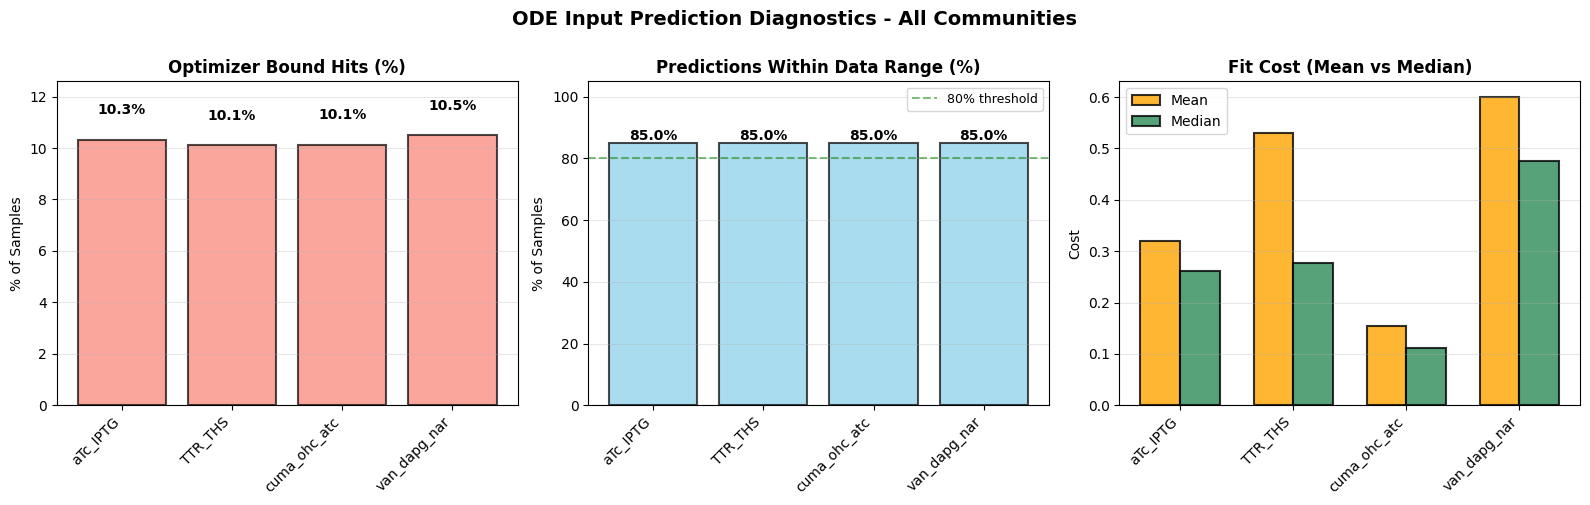

In [4]:
#import python packages
''''
Make sure the bounds lower, does not exclude values. do a throw catch expeections and see if it runs into that.
'''

import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import glob
from sklearn.metrics import r2_score
from scipy.optimize import least_squares
from scipy.integrate import solve_ivp

from data_loading_v5 import define_metadata, convert_reader_data, subtract, normalize 
from mechanistic_model import difeq_newest_test_2, fp_total_timecourse

def get_save_dir(base_dir, community, plasmid=None, inhibitor=None):
    """Helper function to create consistent save directory paths"""
    if community == 'antibiotic_data':
        save_dir = f"{base_dir}/{community}/{plasmid}_{inhibitor}/"
    else:
        save_dir = f"{base_dir}/{community}/"
    os.makedirs(save_dir, exist_ok=True)
    return save_dir

def load_parameters(community, plasmid=None, inhibitor=None):
    """Load all required parameter files for a community"""
    save_dir = get_save_dir("parameter_files", community, plasmid, inhibitor)
    
    # Load alpha parameters (timepoint = 20)
    alpha_files = glob.glob(f'{save_dir}*_20hr_{community}_alphas_mixed.npy')
    alphas = np.load(max(alpha_files))
    
    # Load K parameters (timepoint = 20)
    K_files = glob.glob(f'{save_dir}*_20hr_{community}_K_calc.npy')
    K_calc = np.load(max(K_files))
    
    # Load hill parameters (timepoint = 20)
    hill_files = glob.glob(f'{save_dir}*_20hr_{community}_hill_coef.npy')
    hill_calc = np.load(max(hill_files))
    
    # Load optimized model parameters
    params_files = glob.glob(f'{save_dir}*_{community}_params.npy')
    all_params = np.load(max(params_files))
    
    print(f"Loaded parameters from: {save_dir}")
    return alphas, K_calc, hill_calc, all_params

def prepare_data(community, plasmid=None, inhibitor=None):
    """Load and preprocess all experimental data for a community"""
    # Import metadata
    files, readers, fluors, fluor1, fluor2, fluor3, single_file, sensor_names, \
    sensors, time_vector, od_raws, input_arrays, input_names, fp1_raws, fp2_raws, fp3_raws = \
        define_metadata(community, plasmid, inhibitor)
    
    # Convert reader data
    if community == 'antibiotic_data':
        od_conv = od_raws
        fp1_conv = fp1_raws
        fp2_conv = fp2_raws
        fp3_conv = None
    else:
        od_conv = convert_reader_data(readers, None, od_raws, community)
        fp1_conv = convert_reader_data(readers, fluor1, fp1_raws, community)
        fp2_conv = convert_reader_data(readers, fluor2, fp2_raws, community)
        if sensors == 3:
            fp3_conv = convert_reader_data(readers, fluor3, fp3_raws, community)
        else:
            fp3_conv = None
    
    # Subtract basal expression
    subtracted_fp1, subtracted_fp2, subtracted_fp3 = \
        subtract(community, time_vector, fp1_conv, fp2_conv, fp3_conv, sensors, input_arrays)
    
    # Normalize fluorescence
    normalized_fp1, normalized_fp2, normalized_fp3 = \
        normalize(subtracted_fp1, subtracted_fp2, subtracted_fp3)
    
    # Stack OD time courses
    od_stack = np.empty((0, len(time_vector)), dtype=float)
    for i, reader in enumerate(fluor1):
        od_stack = np.vstack((od_stack, od_conv[i]))
    
    # Concatenate all data
    concat_list = [od_stack, normalized_fp1, normalized_fp2]
    if normalized_fp3 is not None and normalized_fp3.size > 0:
        concat_list.append(normalized_fp3)
    exp_data = np.concatenate(concat_list, axis=1)
    
    # Concatenate input data
    exp_inputs = np.vstack(list(input_arrays.values()))
    
    return exp_data, exp_inputs, sensors, time_vector, input_names

def filter_and_normalize_data(exp_data, exp_inputs, K_calc, hill_calc, sensors, community):
    """Filter data based on threshold limits and normalize by K values"""
    # Extract true K values for each sensor
    true_K = np.zeros(sensors)
    upper = np.zeros(sensors)
    lower = np.zeros(sensors)
    
    for i in range(sensors):
        true_K[i] = K_calc[i * sensors + i]
        upper[i] = true_K[i] * (99 ** (1 / hill_calc[i * sensors + i]))
        lower[i] = true_K[i] / (99 ** (1 / hill_calc[i * sensors + i]))
    
    # Create mask for filtering
    if community in ['cuma_ohc_atc', 'van_dapg_nar', 'antibiotic_data']:
        mask = (exp_inputs > 0).all(axis=1)
    else:
        mask = (exp_inputs >= lower).all(axis=1) & (exp_inputs <= upper).all(axis=1)
    
    # Filter data
    filtered_exp_inputs = exp_inputs[mask]
    filtered_exp_data = exp_data[mask]
    
    # Normalize by K values
    normalized_exp_inputs = filtered_exp_inputs / true_K
    normalized_K_calc = K_calc.reshape((sensors, sensors)) / true_K
    
    return filtered_exp_data, normalized_exp_inputs, normalized_K_calc, true_K

def ode_input_pred(sensors, samples, tspan, all_params, alpha, K, hill, normalized_exp_inputs):
    """Estimate input conditions from time courses using nonlinear optimization"""
    n = sensors
    inits_train = samples[0::len(tspan)]
    
    # Calculate bounds
    filtered_min = np.min(normalized_exp_inputs, axis=0)
    # print("filtered_min", filtered_min)
    filtered_max = np.max(normalized_exp_inputs, axis=0)
    margin_factor = 2.0
    # bounds_lower = np.maximum(0.01, filtered_min / margin_factor)
    # print("bounds_lower", bounds_lower)
    bounds_upper = filtered_max * margin_factor
    bounds = np.array([filtered_min/margin_factor, bounds_upper])
    
    def residual_function(s_ref, y_data, time_range, p_0, all_params, alpha, K, hill):
        params_reshape = all_params.reshape(n, 7)
        
        # Set initial conditions
        od_0 = p_0[0] / 2
        fluor_0 = p_0[1:] / od_0
        yinit = np.zeros(2 * n)
        yinit[:n] = od_0
        yinit[n:] = fluor_0
        
        # Solve ODEs
        sol = solve_ivp(
            lambda t, y: difeq_newest_test_2(t, y, params_reshape, alpha, K, hill, s_ref, n),
            [time_range[0], time_range[-1]], yinit, t_eval=time_range
        )
        
        results = fp_total_timecourse(sol.y, n, n).ravel()
        results = np.hstack(results)
        residuals = results - y_data
        
        return residuals
    
    # Initial guess: diagonal of K matrix
    s_ref = np.diag(K)
    
    # Run optimization
    result = least_squares(
        fun=residual_function, x0=s_ref, bounds=bounds,
        method='trf', args=(samples, tspan, inits_train, all_params, alpha, K, hill),
        max_nfev=300
    )
    
    return result.x, result.cost

def print_diagnostics(s_est, normalized_exp_inputs, test_cost, input_names, sensors):
    """Print comprehensive diagnostics about prediction quality"""
    print("=" * 60)
    print("PREDICTION QUALITY DIAGNOSTICS")
    print("=" * 60)
    
    filtered_min = np.min(normalized_exp_inputs, axis=0)
    filtered_max = np.max(normalized_exp_inputs, axis=0)
    margin_factor = 2.0
    bounds_lower = np.maximum(0.01, filtered_min / margin_factor)
    bounds_upper = filtered_max * margin_factor
    
    # Check bound failures
    bound_failures = np.zeros(len(s_est))
    for i, pred in enumerate(s_est):
        at_lower = np.any(pred <= bounds_lower * 1.01)
        at_upper = np.any(pred >= bounds_upper * 0.99)
        bound_failures[i] = at_lower or at_upper
    
    failed_fits = np.sum(bound_failures)
    print(f"Optimizer failures (hit bounds): {failed_fits}/{len(s_est)} ({100*failed_fits/len(s_est):.1f}%)")
    
    # Per-sensor analysis
    for j in range(sensors):
        at_lower_sensor = np.sum(s_est[:, j] <= bounds_lower[j] * 1.01)
        at_upper_sensor = np.sum(s_est[:, j] >= bounds_upper[j] * 0.99)
        within_data_range = np.sum((s_est[:, j] >= filtered_min[j]) & (s_est[:, j] <= filtered_max[j]))
        print(f"{input_names[j]}: {at_lower_sensor} at lower bound, {at_upper_sensor} at upper bound")
        print(f"  {within_data_range}/{len(s_est)} predictions within original data range ({100*within_data_range/len(s_est):.1f}%)")
    
    # Cost statistics
    print(f"\nCost statistics:")
    print(f"  Mean cost: {np.mean(test_cost):.6f}")
    print(f"  Median cost: {np.median(test_cost):.6f}")
    print(f"  Max cost: {np.max(test_cost):.6f}")
    print(f"  High cost samples (>95th percentile): {np.sum(test_cost > np.percentile(test_cost, 95))}")

def round_to_nearest_half(value):
    """Round value to nearest 0.5"""
    return round(value * 2) / 2

def plot_predictions(s_est, normalized_exp_inputs, true_K, input_names, community, plasmid=None, inhibitor=None):
    """Create and save prediction plots"""
    save_dir = get_save_dir("figures", community, plasmid, inhibitor)
    
    fig_log, ax_log = plt.subplots(1, len(input_names), figsize=(3 * len(input_names), 3))
    if len(input_names) == 1:
        ax_log = [ax_log]  # Make it iterable
    
    # Convert back to original scale
    original_inputs = true_K * normalized_exp_inputs
    predicted_inputs = true_K * s_est
    
    # Ensure no zeros/negatives for log transform
    safe_original = np.maximum(original_inputs, 1e-10)
    safe_predicted = np.maximum(predicted_inputs, 1e-10)
    
    # Take log
    original_inputs_log = np.log10(safe_original)
    predicted_inputs_log = np.log10(safe_predicted)
    
    # Plot each input
    for i in range(len(input_names)):
        min_val = np.min([np.min(original_inputs_log[:, i]), np.min(predicted_inputs_log[:, i])])
        max_val = np.max([np.max(original_inputs_log[:, i]), np.max(predicted_inputs_log[:, i])])
        ticks = [round_to_nearest_half(min_val), round_to_nearest_half((min_val + max_val) / 2), round_to_nearest_half(max_val)]
        min_val_w_ticks = np.min([min_val, np.min(ticks)])
        max_val_w_ticks = np.max([max_val, np.max(ticks)])
        data_range = max_val_w_ticks - min_val_w_ticks
        padding = 0.05 * data_range
        new_min = min_val_w_ticks - padding
        new_max = max_val_w_ticks + padding
        
        ax_log[i].scatter(original_inputs_log[:, i], predicted_inputs_log[:, i], s=30, color='blue', alpha=0.5)
        ax_log[i].plot([new_min, new_max], [new_min, new_max], 'r')
        ax_log[i].set_aspect('equal', adjustable='box')
        ax_log[i].set_title(f'{input_names[i]} predictions (log)')
        ax_log[i].set_xticks(ticks)
        ax_log[i].set_yticks(ticks)
        
        r2_log = r2_score(original_inputs_log[:, i], predicted_inputs_log[:, i])
        ax_log[i].text(0.05, 0.95, fr'$R^2$ = {r2_log:.4f}', transform=ax_log[i].transAxes, verticalalignment='top')
        ax_log[i].set_xlabel(f'True log({input_names[i]})')
        ax_log[i].set_ylabel(f'Predicted log({input_names[i]})')
    
    plt.tight_layout()
    fig_log.savefig(f'{save_dir}ODE_input_predictions_log_scale.svg', format='svg')
    plt.close()
    print(f"Plot saved to: {save_dir}ODE_input_predictions_log_scale.svg")

def run_ode_predictions(community, plasmid=None, inhibitor=None):
    """Main function to run ODE predictions for a single community"""
    print("\n" + "=" * 60)
    print(f"PROCESSING COMMUNITY: {community}")
    if community == 'antibiotic_data':
        print(f"Plasmid: {plasmid}, Inhibitor: {inhibitor}")
    print("=" * 60 + "\n")
    
    # Load parameters
    alphas, K_calc, hill_calc, all_params = load_parameters(community, plasmid, inhibitor)
    
    # Prepare data
    exp_data, exp_inputs, sensors, time_vector, input_names = prepare_data(community, plasmid, inhibitor)
    
    # Filter and normalize
    filtered_exp_data, normalized_exp_inputs, normalized_K_calc, true_K = \
        filter_and_normalize_data(exp_data, exp_inputs, K_calc, hill_calc, sensors, community)
    
    # Reshape parameters
    alpha = alphas.reshape((sensors, sensors))
    hill = hill_calc.reshape((sensors, sensors))
    
    # Initialize output arrays
    s_est = np.zeros((len(filtered_exp_data), sensors))
    test_cost = np.zeros(len(filtered_exp_data))
    
    # Run optimization for each sample
    print(f"Running ODE predictions for {len(filtered_exp_data)} samples...")
    for i, sample in enumerate(filtered_exp_data):
        s_est[i], test_cost[i] = ode_input_pred(
            sensors, sample, time_vector, all_params, alpha, normalized_K_calc, hill, normalized_exp_inputs
        )
        if (i + 1) % 20 == 0:
            print(f"  Processed {i+1}/{len(filtered_exp_data)} samples")
    
    # Save predictions
    save_dir = get_save_dir("ODE_predictions", community, plasmid, inhibitor)
    datestamp = datetime.now().strftime("%Y-%m-%d")
    np.save(f'{save_dir}{datestamp}_{community}_ode_predictions.npy', s_est)
    np.save(f'{save_dir}{datestamp}_{community}_ode_input_predictions_cost.npy', test_cost)
    print(f"\nPredictions saved to: {save_dir}")

    
    # Print diagnostics
    print_diagnostics(s_est, normalized_exp_inputs, test_cost, input_names, sensors)
    
    # Create plots
    print("\nCreating log scale plot for comparison...")
    plot_predictions(s_est, normalized_exp_inputs, true_K, input_names, community, plasmid, inhibitor)
    
    print(f"\n✓ Completed processing for {community}")
    return s_est, test_cost

# =============================================================================
# MAIN EXECUTION
# =============================================================================

if __name__ == "__main__":
    # Define all communities to process (excluding antibiotic_data as requested)
    communities_to_process = ['aTc_IPTG', 'TTR_THS', 'cuma_ohc_atc', 'van_dapg_nar', 'ttr_ths_ph']
    
    # Dictionary to store results
    all_results = {}
    
    # Process each community
    for community in communities_to_process:
        try:
            s_est, test_cost = run_ode_predictions(community)
            all_results[community] = {'predictions': s_est, 'cost': test_cost}
        except Exception as e:
            print(f"\n✗ ERROR processing {community}: {str(e)}")
            continue
    
    # Summary
    print("\n" + "=" * 60)
    print("PROCESSING COMPLETE - SUMMARY")
    print("=" * 60)
    for community in communities_to_process:
        if community in all_results:
            print(f"✓ {community}: {len(all_results[community]['predictions'])} predictions")
        else:
            print(f"✗ {community}: FAILED")
    plot_cumulative_diagnostics(all_results, communities_to_process)


### Analysis of ODE Input Prediction Results

- **aTc:** The optimizer frequently hits the **upper bound (20 samples)**, suggesting it “wants” to predict higher concentrations than the allowed range. 
- **Cost distribution:** The **median cost is consistently lower than the mean**, implying the presence of **outliers** with high residual errors that skew the average.  
- **IPTG:** Behavior is **well captured**, with minimal bound hits and stable fits across samples.  
- **THS:** This sensor **behaves poorly**, often producing bound hits and extrapolations outside the experimental range, signaling possible parameter or identifiability issues.  
- **cuma_ohc_atc:** Overall the **best-performing system**, with few optimizer hits, stable costs, and predictions staying within the experimental domain.  
- **NAR:** The **NAR input frequently reaches its bounds**, suggesting the model struggles to capture its dynamics accurately.